# Bayesian inference of network structure from unreliable data 

A tutorial on how to use our [Stan](http://mc-stan.org) model to infer the structure and properties of empirical complex systems from noisy, error-prone measurements.
Based on the article ["Bayesian inference of network structure from unreliable data,"](https://academic.oup.com/comnet/article/8/6/cnaa046/6161493), by [J.-G. Young](http://jgyoung.ca), [G. T. Cantwell](https://www.george-cantwell.com/), and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).


**Author**: J.-G. Young <jean-gabriel.young@uvm.edu> <br/> 
**Date**: August 2020 <br/>
**License**: CC-BY-4.0<br/>
**Note:** This notebook uses `cmdstanpy` to interface with Stan. See the [README](../README.md) for setup instructions, or check the project page for other [Stan interfaces](https://mc-stan.org/users/interfaces/) (R, Julia, etc.).

In [1]:
# external
from cmdstanpy import CmdStanModel
import cmdstanpy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

# core python modules
import sys
import itertools as it

%matplotlib inline


print('python', sys.version)
print('cmdstanpy', cmdstanpy.__version__)
print('numpy', np.__version__)
print('networkx', nx.__version__)
print('pandas', pd.__version__)

python 3.12.9 (main, Mar 11 2025, 17:26:57) [Clang 20.1.0 ]
cmdstanpy 1.3.0
numpy 2.4.1
networkx 3.6.1
pandas 2.3.3


## The data

In this notebook, we reproduce the case-study of the dolphin network appearing in Section IIIA of our paper, ["Bayesian inference of network structure from unreliable data."](https://academic.oup.com/comnet/article/8/6/cnaa046/6161493)
Let's load this data first.

In [2]:
X = np.array(pd.read_csv('dolphin.csv', names=range(13)))
X[np.diag_indices(13)] = 0

To get a feeling for the data, we can start by reproducing Figure 1, which shows the raw data.

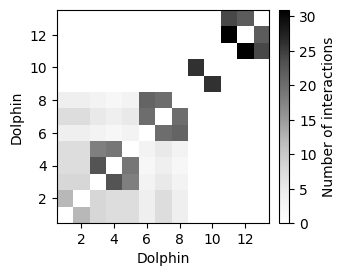

In [3]:
def set_axes():
    """Set origin at bottom left and set ticks"""
    plt.xticks(np.arange(1, 13, 2), np.arange(2, 14, 2))
    plt.yticks(np.arange(1, 13, 2), np.arange(2, 14, 2))
    plt.xlim(-0.5, 12.5)
    plt.ylim(-0.5, 12.5)

plt.figure(figsize=(3,3))
set_axes()
im=plt.imshow(X, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im,fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin');

It is a symmetric 13x13 array, whose entry `X[i,j]` gives the number of observed interactions between dolphins `i` and `j`. To see how these entries are distributed, let's also plot the histogram of the entries --- that's Figure 1b.

In [4]:
# Construct the histogram of interaction
num_in_class = np.zeros(X.max() + 1)
obs_in_class = list(range(X.max() + 1))
for i, j in it.combinations(range(13), 2):
    num_in_class[X[i, j]] += 1

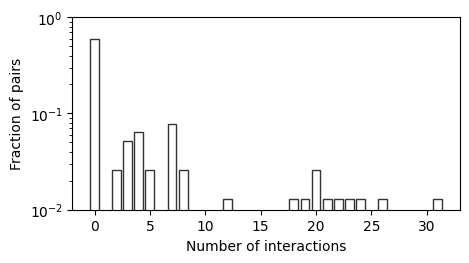

In [5]:
plt.figure(figsize=(5,2.5))

plt.bar(obs_in_class, num_in_class / np.sum(num_in_class), edgecolor='#333333', color='w')
plt.gca().set_yscale('log')
plt.xlabel('Number of interactions')
plt.ylabel('Fraction of pairs')
plt.ylim(1e-2,1);

Many dolphins don't interact at all, but some interact as many as 31 times.

## The model

In the paper, we propose that as a first model, we can suppose that two dolphins interact a lot when they are connected, whereas an absence of ties translates into few recorded interactions.
Hence, we propose to model `X[i,j]` as a Poisson random variable, with a large mean `lambda_1` if `i` and `j` are connected, and with a smaller  mean `lambda_0<lambda_1` otherwise. In the notation used in the paper, we have the model

![](model_1.png)

where `mu_ij(0)` stands for the distribution of `X[i,j]` when `i` and `j` are not connected, and similarly for  `mu_ij(1)`. 


Further, we argue for the following prior for the edges

![](prior.png)

That is, we assume that the edges are all equally likely a priori, with unknown probability `rho`. The model is completed by using semi-normal distribution as priors for `lambda_0` and `lambda_1`, and a uniform prior on `rho`. (See the paper for more details on the notation and model.)

## Estimation

As we show in the paper, one can fit this model by sampling from the distribution of parameters---`lambda_0`, `lambda_1` and `rho`---conditioned on `X`, and then from the distribution of networks conditioned on these parameters. (This is possible because the model is essentially a [finite mixture](https://en.m.wikipedia.org/wiki/Mixture_model) whose components are indexed by pairs of nodes).

The first part, sampling the parameters, is done with `stan`.

### Sampling parameters

#### Stan model

First, we have to load the `stan` model. It can be compiled together with all the other example models, using the provided compiler script. Alternatively, we can compile it inline:

In [6]:
model = CmdStanModel(stan_file='../examples/poisson_data_ER_prior.stan')

In [7]:
# To force recompilation:
# model = CmdStanModel(stan_file='../examples/poisson_data_ER_prior.stan', force_compile=True)

The model code looks like this, and implements the parameter sampling step

In [8]:
print(model.code())

data {
  int<lower=1> n;
  array[n, n] int<lower=0> X;
  array[2] real<lower=0> rates_std_prior;
  array[2] real<lower=0> rho_prior;
}
parameters {
  positive_ordered[2] rates;
  real<lower=0, upper=1> rho;
}
model {
  rates[1] ~ normal(1, rates_std_prior[1]);
  rates[2] ~ normal(1, rates_std_prior[2]);
  rho ~ beta(rho_prior[1], rho_prior[2]);

  for (i in 1:n) {
    for (j in i + 1:n) {
      real log_mu_ij_0 = poisson_lpmf(X[i, j] | rates[1]);
      real log_mu_ij_1 = poisson_lpmf(X[i, j] | rates[2]);

      real log_nu_ij_0 = bernoulli_lpmf(0 | rho);
      real log_nu_ij_1 = bernoulli_lpmf(1 | rho);

      real z_ij_0 = log_mu_ij_0 + log_nu_ij_0;
      real z_ij_1 = log_mu_ij_1 + log_nu_ij_1;
      if (z_ij_0 > z_ij_1) {target += z_ij_0 + log1p_exp(z_ij_1 - z_ij_0);}
      else {target += z_ij_1 + log1p_exp(z_ij_0 - z_ij_1);}
    }
  }
}
generated quantities {
  array[n, n] real Q;
  for (i in 1:n) {
    Q[i, i] = 0;
    for (j in i+1:n) {
      real log_mu_ij_0 = poisson_lpmf(X[i,

#### Some stan background (skip if you just want results)

Note the variables `log_mu_ij_0`, `log_mu_ij_1` , `log_nu_ij_0` and `log_nu_ij_1`. These variables are where the model is specified. In the present case, we have specified that `mu_ij` is a Poisson variable, and that `nu_ij` is a Bernoulli variable. (They appear twice, once in the model block and once in the generated quantities block, due to idiosyncratic details of how `Stan` works.)

Much of the remaining code is boilerplate, and provided already in our [templates](https://github.com/jg-you/noisy-networks-measurements/tree/master/templates). 

The fields that are specific to the present models are, in the `data` block:
* `rates_std_prior` are the standard deviations for the priors on the rates  `lambda_0` and `lambda_1`
* `rho_prior` are parameters of the prior on rho, which is set to a Beta distribution here. We'll use 1 in both entries to encode a uniform distribution.

The `parameters` fields also contain model-specific information. In this case, the parameters that will be sampled are
* `rates`: The rates  `lambda_0` and `lambda_1`
* `rho`: The density

Lastly, the priors that we chose appear at the top of the `model` block.

#### Sampling

So let's fit the model to the dolphin data.
We'll use the default sampling parameters of `Stan`: 4 independent MCMC chains, of length 2000 each, with half of the iterations spent in burn-in.

In [9]:
# Sample
fit = model.sample(data={"n": X.shape[0],
                         "X": X,
                         "rates_std_prior": [100, 100],
                         'rho_prior': [1, 1]})

# Extract variables for convenient access
rho = fit.stan_variable('rho')
rates = fit.stan_variable('rates')
Q_samples = fit.stan_variable('Q')
lp = fit.method_variables()['lp__'].T.flatten()  # flatten: all of chain1, then chain2, etc.

15:42:34 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:42:34 - cmdstanpy - INFO - CmdStan done processing.


Let's take a look at the fit.

In [10]:
print(fit.summary())

                Mean          MCSE    StdDev           MAD            5%  \
lp__     -215.927000  6.498530e-02  1.614890  1.336820e+00 -2.191380e+02   
rates[1]    0.607463  9.356570e-03  0.225157  1.846890e-01  1.285010e-01   
rates[2]   14.229700  6.248100e-02  1.502620  1.328820e+00  1.130450e+01   
rho         0.284433  2.403270e-03  0.064292  6.127420e-02  1.880880e-01   
Q[1,1]      0.000000           NaN  0.000000  0.000000e+00  0.000000e+00   
...              ...           ...       ...           ...           ...   
Q[13,9]     0.000002  2.356300e-07  0.000005  4.154910e-07  5.123050e-08   
Q[13,10]    0.000002  2.356300e-07  0.000005  4.154910e-07  5.123050e-08   
Q[13,11]    1.000000           NaN  0.000000  0.000000e+00  1.000000e+00   
Q[13,12]    1.000000           NaN  0.000000  0.000000e+00  1.000000e+00   
Q[13,13]    0.000000           NaN  0.000000  0.000000e+00  0.000000e+00   

                   50%         95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__     

Everything appears normal save for a few entries of `Q[i,j]`---the posterior probability that an edge exists---that do not have any variability.
In fact, this lack of variability causes a warning!
One should look into [**any** warning messages](https://mc-stan.org/misc/warnings.html) returned by stan.
They are usually a sign that something's wrong with the model.
In our case, however, this is expected since the faulty entries are the diagonal of `Q`, which we set to 0 manually in the model since we don't consider self-loops. So there's no actual error---we can proceed.

We can do a few extra sanity checks. For example, let's look at log posterior probability across independent chains:

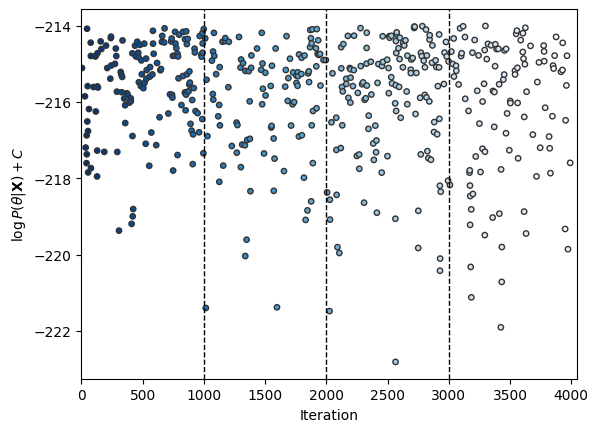

In [11]:
subset = sorted(np.random.choice(range(len(lp)), size=500, replace=False))
plt.scatter(subset, lp[subset], s=15, edgecolor='#333333', linewidth=1, c=subset, alpha=1, cmap=plt.cm.Blues_r)
plt.xlabel('Iteration')
plt.ylabel(r'$\log P(\theta|\mathbf{X}) + C$')
for bar in [1000, 2000, 3000]:
    plt.axvline(bar, c='k', ls='--', lw=1)
plt.xlim(0, len(lp) + 50);

It is consistent across chains, and appears to have reached a steady-state. To see if the samples are also qualitatively similar, we can look at the pair-plot for the key parameters

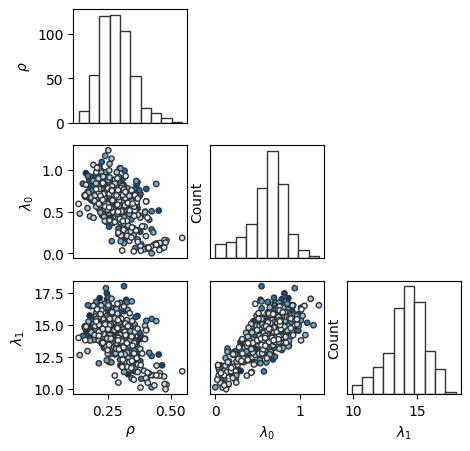

In [12]:
import seaborn as sns
pp = pd.DataFrame(np.array([rho, rates[:, 0], rates[:, 1]]).T, columns=[r'$\rho$', r'$\lambda_0$', r'$\lambda_1$'])
plt.figure(figsize=(5, 5))
plot_idx = {0: 1, 1: 4, 2: 7, 3: 5, 4: 8, 5: 9}
plot_data = [{'name': 'rho', 'label': r'$\rho$', 'samples': rho[subset]},
             {'name': 'l0', 'label': r'$\lambda_0$', 'samples': rates[subset, 0]},
             {'name': 'l1', 'label': r'$\lambda_1$', 'samples': rates[subset, 1]}]
for i, pdata in enumerate(it.combinations_with_replacement(plot_data, 2)):
    plt.subplot(3, 3, plot_idx[i])
    if pdata[0]['name'] == pdata[1]['name']:
        # diagonal, histogram
        sns.histplot(pdata[0]['samples'], kde=False, color='w', edgecolor='#333333', linewidth=1, alpha=1, bins=10)
    else:
        # pairs
        plt.scatter(pdata[0]['samples'], pdata[1]['samples'], s=15, edgecolor='#333333', linewidth=1, c=subset, alpha=1, cmap=plt.cm.Blues_r)
    if plot_idx[i] < 7:
        plt.xticks([], [])
    else:
        plt.xlabel(pdata[0]['label'])
    if plot_idx[i] not in [1, 4, 7]:
        plt.yticks([], [])
    else:
        plt.ylabel(pdata[1]['label'])

and again we see no apparent issue.

As we see from this figure, the posterior distribution of the rates are centered close to 0 and 15. The estimated density is around 0.25.  

So we have sampled the parameters of our model!

### Network samples

#### Posterior probability of edges

The next step is to sample networks based on the samples of `lambda_0`, `lambda_1` and `rho`. In the paper, we show that one can use these parameters and the data matrix `X` to compute the posterior probability `Q_ij` that there is an edge between node `i` and `j`. As we have already seen, the `stan` model computes this probability automatically and returns it too in the `fit` object.

Let's focus on the first sample:

In [13]:
sample_idx = 0
print(rho[sample_idx], rates[sample_idx, 0], rates[sample_idx, 1])

0.28403573 0.46646522 13.570186


The associated matrix of edge probabilities look like:

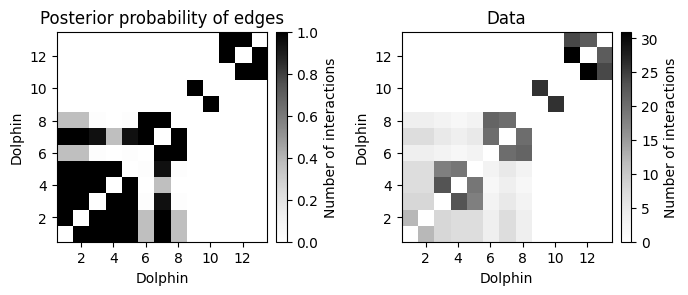

In [14]:
plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.title('Posterior probability of edges')
set_axes()
im = plt.imshow(Q_samples[sample_idx, :], cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im, fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')


plt.subplot(122)
plt.title('Data')
im = plt.imshow(X, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im, fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')
plt.tight_layout()

Comparing with the data, there's a clear correlation between the prediction and the number of observed interactions.

We can average these matrices to get a robust posterior estimate of the probability that every pair is connected:

In [15]:
Q = np.mean(Q_samples, axis=0)

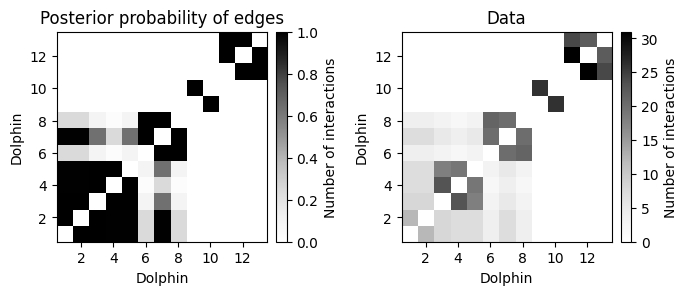

In [16]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.title('Posterior probability of edges')
set_axes()
im=plt.imshow(Q, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im,fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')


plt.subplot(122)
plt.title('Data')
im=plt.imshow(X, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im,fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')
plt.tight_layout()

The predictions are similar, but now account for a broad range of parametrizations, not just the particular parameters of the first sample.

#### Network samples

Neither the `Q` matrices nor their averages are networks; they give the posterior probability of the edges.

If we want to compute network quantities, we have to generate network *samples* from these matrices. 
For example, using the first sampled  matrix `Q`, we can generate a sample thus:

In [17]:
G = nx.Graph()
Q = Q_samples[sample_idx, :]
for i, j in it.combinations(range(13), 2):
    if np.random.rand() < Q[i, j]:
        G.add_edge(i, j)

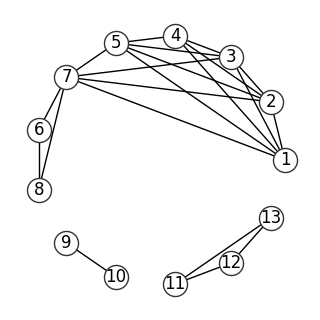

In [18]:
plt.figure(figsize=(3,3))
pos = nx.circular_layout(G)

nx.draw(G, pos=pos, linewidths=1, edgecolors='#333333', node_color='w')
nx.draw_networkx_labels(G, pos, labels={i : str(i + 1) for i in range(13)}, font_color='k')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2);

#### Posterior averages over networks

To evaluate general averages over networks, we just have to loop over parameter samples, and generate a few networks for each of them. Then we'll be able to compute a histogram of the network quantity with these networks.

As an example, let's compute the posterior distribution of transitivity coefficients:

In [19]:
values = []

for param_id in range(100):  # loop over the first 100 network samples
    for net_id in range(10):  # generate 10 network samples for each parameter samples
        G = nx.Graph()
        Q = Q_samples[param_id, :]
        for i, j in it.combinations(range(13), 2):
            if np.random.rand() < Q[i, j]:
                G.add_edge(i, j)
        values.append(nx.transitivity(G))

(0.5, 1.0)

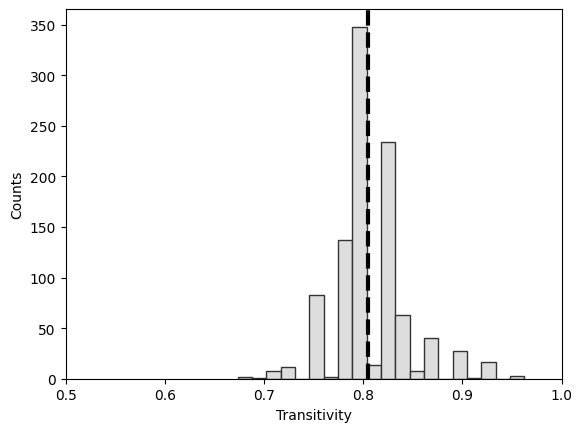

In [20]:
plt.hist(values, edgecolor='#333333', color='#DDDDDD', bins=20)
plt.xlabel('Transitivity')
plt.ylabel('Counts')
plt.axvline(np.mean(values), c='k', ls='--', lw=3)
plt.xlim(0.5, 1)

So we now have a mean transitivity and error bars! Note that thresholding would have given a much different answer:

In [21]:
G = nx.Graph()
for i,j in it.combinations(range(13),2):
    if X[i,j] > 0:
        G.add_edge(i,j)
print("Tresholded transitivity:", nx.transitivity(G))

Tresholded transitivity: 1.0


## Posterior-predictive check

We have successfully obtained a fit of the model. The next step is to verify whether they actually fit the data well --- if they don't, then we can't trust the inference, and we'll have to revisit the model.

We'll do our model criticism using several standard Bayesian tools. First, let's compute the mean of the posterior predictive distribution, i.e., the mean data matrix `X_tilde` we get when we feed the samples back in the likelihood.

In [22]:
X_tilde = np.zeros((13, 13))

for param_id in range(100):  # loop over the first 100 network samples
    for net_id in range(5):  # simulate 5 network samples for each parameter samples
        G = nx.Graph()
        Q = Q_samples[param_id, :]
        for i, j in it.combinations(range(13), 2):
            if np.random.rand() < Q[i, j]:
                X_tilde[i, j] += float(np.random.poisson(rates[param_id, 1]))
            else:
                X_tilde[i, j] += float(np.random.poisson(rates[param_id, 0]))

# Normalize and symmetrize
X_tilde /= 500
X_tilde += X_tilde.T

(There are faster ways to do this if we use a bit of maths, but this simulation technique will do for our purpose.)

#### Visual assessment

We can now compare this average posterior predictive matrix to the input `X`, to see where the model diverges from the true data and in what ways:

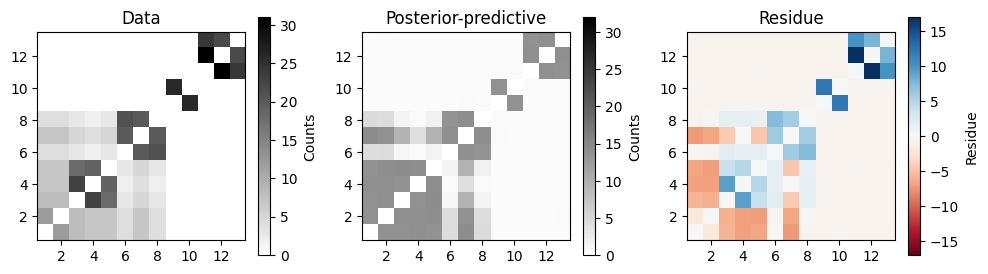

In [23]:
plt.figure(figsize=(10,2.8))

plt.subplot(131)
plt.title('Data')
plt.imshow(X, cmap=plt.cm.gray_r)
plt.colorbar(label='Counts')
set_axes()

plt.subplot(132)
plt.title('Posterior-predictive')
plt.imshow(X_tilde, vmin=0, vmax=32, cmap=plt.cm.gray_r)
plt.colorbar(label='Counts')
set_axes()


plt.subplot(133)
plt.title('Residue')
plt.imshow(X  - X_tilde, vmin=-17, vmax=17, cmap=plt.cm.RdBu)
plt.colorbar(label='Residue')
set_axes()


plt.tight_layout(pad=1)

Visually the model is good at ***not*** placing any interactions where there's none in the real data.
But it fails to account for both the mid-density and high-density regions of the data matrix.

We can also see this by comparing the observed counts versus the predicted counts in a scatter plot.

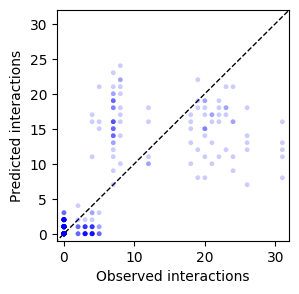

In [24]:
plt.figure(figsize=(3, 3))
for sample_id in range(5):
    # create artificial data sets
    A = np.random.rand(13, 13) < Q_samples[sample_id, :]
    A[np.triu_indices(13, k=1)] = A.T[np.triu_indices(13, k=1)]
    X_tilde_0 = np.random.poisson(rates[sample_id, 0], size=Q.shape)
    X_tilde_1 = np.random.poisson(rates[sample_id, 1], size=Q.shape)
    X_tilde = (1 - A) * X_tilde_0 + A * X_tilde_1
    plt.scatter(X[np.triu_indices(13, k=1)], X_tilde[np.triu_indices(13, k=1)], c='blue', s=12, alpha=0.2, edgecolor='none', zorder=10)

plt.plot([-10, 50], [-10, 50], c='k', ls='--', lw=1)
plt.xlabel('Observed interactions')
plt.ylabel('Predicted interactions')
plt.xlim(-1, 32)
plt.ylim(-1, 32)
plt.gca().set_facecolor("none")
plt.gca().set_facecolor("none")

The points are far from the diagonal!

#### Formal assessment (skip if you just want results)

To get a more formal assessment of goodness-of-fit, we can also use the realized discrepancy technique proposed by [Gelman, Meng. and Stern (1996)](http://www.stat.columbia.edu/~gelman/research/published/A6n41.pdf).
Basically, we must generate a bunch of parameter samples, and (i) compute how well they fit the actual data, as well  as (ii) how well they fit an artificial data set generated with the samples themselves.

If the model is a good fit but does not overfit, we'll see no difference between (i) and (ii) on average.

We use the discrepancy to compute the quality of the fit provided by a particular parametrization:

![](discrepancy.png)

where `X_tilde` is the average synthetic data when the parameters are fixed (`theta` stands in for `rho`,`lambda_0` and `lambda_1`).

In [25]:
def discrepancy(X, Q, rates):
    """Compute the discrepancy"""
    # One can check that <X_tilde_ij> = Q_ij lambda_1 + (1 - Q_ij) lambda_0 in our model.
    X_tilde_mat = Q * rates[1] + (1 - Q) * rates[0]
    # Avoid double counting and numerically ill-defined 0*log(0) by selecting indices
    idx = np.triu_indices(13, k=1)
    idx2 = np.where(X[idx] > 0)[0]
    return np.sum(X[idx][idx2] * np.log(X[idx][idx2] / X_tilde_mat[idx][idx2]))


# Compute discrepancy distribution
d_data = np.zeros(500)        # data discrepancy
d_artificial = np.zeros(500)  # artificial data discrepancy

for sample_id in range(500):
    # Generate artificial data set
    A = np.random.rand(13, 13) < Q_samples[sample_id, :]
    A[np.triu_indices(13, k=1)] = A.T[np.triu_indices(13, k=1)]
    X_tilde_0 = np.random.poisson(rates[sample_id, 0], size=Q.shape)
    X_tilde_1 = np.random.poisson(rates[sample_id, 1], size=Q.shape)
    X_tilde = (1 - A) * X_tilde_0 + A * X_tilde_1
    # calculate discrepancy
    d_data[sample_id] = discrepancy(X, Q_samples[sample_id, :], rates[sample_id, :])
    d_artificial[sample_id] = discrepancy(X_tilde, Q_samples[sample_id, :], rates[sample_id, :])

Text(30, 280, 'P-value=0.142')

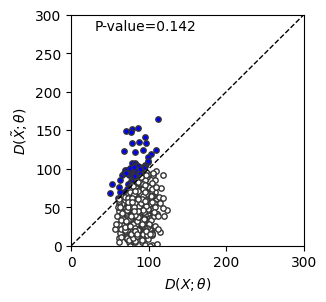

In [26]:
plt.figure(figsize=(3,3))
plt.scatter(d_data[d_data<d_artificial], d_artificial[d_data<d_artificial], s=15, edgecolor='#333333', linewidth=1, color='blue', alpha=1)
plt.scatter(d_data[d_data>d_artificial], d_artificial[d_data>d_artificial], s=15, edgecolor='#333333', linewidth=1, color='w', alpha=1)
plt.plot([0, 300], [0, 300], c='k', ls='--', lw=1)
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel(r'$D(X;\theta)$')
plt.ylabel(r'$D(\tilde{X};\theta)$')
plt.text(30, 280, "P-value=" + str(len(d_artificial[d_data<d_artificial]) / 500))

The data--model comparison yields lower discrepancy than the model--model comparison in only about 15% of cases. Hence, the model is not a great fit formally either.

## Revisiting the model

#### Improved model


In the paper, we argue that we can fix the model by adding a new edge type to the network: strong ties, associated with a mean number of observed interactions `lambda_2 > lambda_1`.


Let's load this model..

In [27]:
model = CmdStanModel(stan_file='../examples/multitype_poisson_data_ER_prior.stan')

In [28]:
# To force recompilation:
# model = CmdStanModel(stan_file='../examples/multitype_poisson_data_ER_prior.stan', force_compile=True)

In [29]:
print(model.code())

data {
  int<lower=1> n;
  array[n, n] int<lower=0> X;
  int T; // number of edge types
  array[T] real<lower=0> rates_std_prior;
}
parameters {
  positive_ordered[T] rates;
  simplex[T] rho;
}
model {
  for (k in 1:T)
  {
    rates[k] ~ normal(1, rates_std_prior[k]);
  }

  for (i in 1:n) {
    for (j in i + 1:n) {
      vector[T] z_ij;
      vector[T] z_max_vector;
      real z_max;
      for (k in 1:T) {
        real log_mu_ij_k = poisson_lpmf(X[i, j] | rates[k]);
        real log_nu_ij_k = log(rho[k]);

        z_ij[k] = log_mu_ij_k + log_nu_ij_k;
      }
      z_max = max(z_ij);
      z_max_vector = rep_vector(z_max, T);
      target += z_max + log_sum_exp(z_ij - z_max_vector);
    }
  }
}
generated quantities {
  array[n, n, T] real Q;
  for (i in 1:n) {
    for (k in 1:T) {
      Q[i, i, k] = 0;
    }
    for (j in i+1:n) {
      vector[T] z_ij;
      real accu;
      for (k in 1:T)
      {
        real log_mu_ij_k = poisson_lpmf(X[i, j] | rates[k]);
        real log_nu_ij_k = l

This model is almost identical to before, but now has `T` edge types (we'll use 3 to encode: no edge, weak edges, strong edges).
One notable difference in the code is that `rho` is now encoded as a simplex.

`rho[0]` denotes the prior probability that there's no edge, `rho[1]` the probability that there's a weak edge, and `rho[2]` the probability that there's a strong edge.

#### Sanity check

As a sanity check let's re-run the model on our data with T=2.
We should get the same output as before.

In [30]:
# Sample
fit = model.sample(data={"n": X.shape[0],
                         "X": X,
                         'T': 2,
                         "rates_std_prior": [100, 100]})

# Extract variables
rho = fit.stan_variable('rho')
rates = fit.stan_variable('rates')
Q_samples = fit.stan_variable('Q')

15:42:45 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:42:46 - cmdstanpy - INFO - CmdStan done processing.


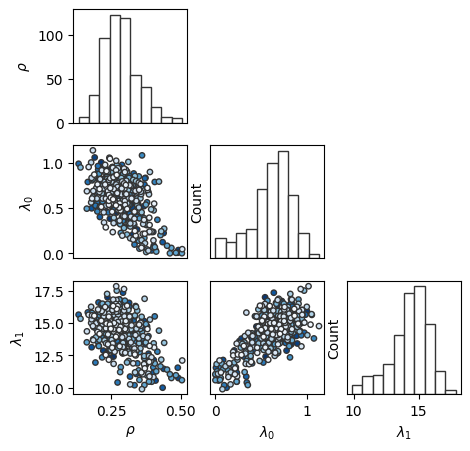

In [31]:
pp = pd.DataFrame(np.array([rho[:, 1], rates[:, 0], rates[:, 1]]).T, columns=[r'$\rho$', r'$\lambda_0$', r'$\lambda_1$'])
plt.figure(figsize=(5, 5))
plot_idx = {0: 1, 1: 4, 2: 7, 3: 5, 4: 8, 5: 9}
plot_data = [{'name': 'rho', 'label': r'$\rho$', 'samples': rho[subset, 1]},
             {'name': 'l0', 'label': r'$\lambda_0$', 'samples': rates[subset, 0]},
             {'name': 'l1', 'label': r'$\lambda_1$', 'samples': rates[subset, 1]}]
for i, pdata in enumerate(it.combinations_with_replacement(plot_data, 2)):
    plt.subplot(3, 3, plot_idx[i])
    if pdata[0]['name'] == pdata[1]['name']:
        # diagonal, histogram
        sns.histplot(pdata[0]['samples'], kde=False, color='w', edgecolor='#333333', linewidth=1, alpha=1, bins=10)
    else:
        # pairs
        plt.scatter(pdata[0]['samples'], pdata[1]['samples'], s=15, edgecolor='#333333', linewidth=1, c=subset, alpha=1, cmap=plt.cm.Blues_r)
    if plot_idx[i] < 7:
        plt.xticks([], [])
    else:
        plt.xlabel(pdata[0]['label'])
    if plot_idx[i] not in [1, 4, 7]:
        plt.yticks([], [])
    else:
        plt.ylabel(pdata[1]['label'])

#### Estimation with the improved model

And indeed we find the same results! This just confirms that the model behaves as expected. Now for `T=3`...

In [32]:
# Sample
fit = model.sample(data={"n": X.shape[0],
                         "X": X,
                         'T': 3,
                         "rates_std_prior": [100, 100, 100]})

# Extract variables
rho = fit.stan_variable('rho')
rates = fit.stan_variable('rates')
Q_samples = fit.stan_variable('Q')

15:42:48 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:42:49 - cmdstanpy - INFO - CmdStan done processing.


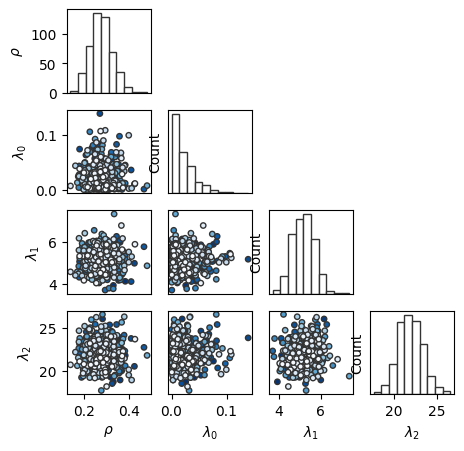

In [33]:
pp = pd.DataFrame(np.array([rho[:, 1], rates[:, 0], rates[:, 1], rates[:, 2]]).T, columns=[r'$\rho$', r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$'])
plt.figure(figsize=(5, 5))
plot_idx = {0: 1, 1: 5, 2: 9, 3: 13, 4: 6, 5: 10, 6: 14, 7: 11, 8: 15, 9: 16}
plot_data = [{'name': 'rho', 'label': r'$\rho$', 'samples': rho[subset, 1]},
             {'name': 'l0', 'label': r'$\lambda_0$', 'samples': rates[subset, 0]},
             {'name': 'l1', 'label': r'$\lambda_1$', 'samples': rates[subset, 1]},
             {'name': 'l2', 'label': r'$\lambda_2$', 'samples': rates[subset, 2]}]
for i, pdata in enumerate(it.combinations_with_replacement(plot_data, 2)):
    plt.subplot(4, 4, plot_idx[i])
    if pdata[0]['name'] == pdata[1]['name']:
        # diagonal, histogram
        sns.histplot(pdata[0]['samples'], kde=False, color='w', edgecolor='#333333', linewidth=1, alpha=1, bins=10)
    else:
        # pairs
        plt.scatter(pdata[0]['samples'], pdata[1]['samples'], s=15, edgecolor='#333333', linewidth=1, c=subset, alpha=1, cmap=plt.cm.Blues_r)
    if plot_idx[i] < 13:
        plt.xticks([], [])
    else:
        plt.xlabel(pdata[0]['label'])
    if plot_idx[i] not in [1, 5, 9, 13]:
        plt.yticks([], [])
    else:
        plt.ylabel(pdata[1]['label'])

We now get a fit where `lambda_0` is still small, but where `lambda_1` is now much smaller than before (about 5, versus ~15). The new parameter `lambda_2` has a high mean: On average, a strong tie translates to ~22 interactions.

What happened is that we separate the class of connected dolphin pairs in two: one with strong ties and one with weak ties. As a result, the mean number of interactions shifted from an in-between (15), to two extremes (5 and 22).

We can visualize the average predicted network with a graph, by (i) placing a **gray edge** between pairs of nodes that have a large posterior probability of being connected by a **weak tie**, and (ii) placing a **blue edge** between pairs of nodes that have a large posterior probability of being connected by a **strong tie**.

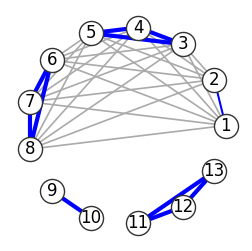

In [34]:
Q0 = np.mean(Q_samples[:, :, :, 0], axis=0)
Q1 = np.mean(Q_samples[:, :, :, 1], axis=0)
Q2 = np.ones_like(Q0) - Q1 - Q0

# Zero out diagonals to avoid self-loops
np.fill_diagonal(Q1, 0)
np.fill_diagonal(Q2, 0)

G1 = nx.Graph(Q1)
G2 = nx.Graph(Q2)
pos = nx.circular_layout(G1)
for u, v in it.combinations(G1.nodes(), 2):
    if Q1[u, v] < 0.1:
        G1.remove_edge(u, v)
for u, v in it.combinations(G1.nodes(), 2):
    if Q2[u, v] < 0.1:
        G2.remove_edge(u, v)
        

plt.figure(figsize=(3, 3))
nx.draw_networkx_nodes(G1, pos=pos, node_color='w', edgecolors='#333333')
nx.draw_networkx_labels(G1, pos, labels={i: str(i + 1) for i in range(13)}, font_color='k')

w1 = nx.get_edge_attributes(G1, 'weight')
w2 = nx.get_edge_attributes(G2, 'weight')
nx.draw_networkx_edges(G1, pos=pos, width=[1.2 * w1[e] for e in G1.edges()], edge_color="#AAAAAA")
nx.draw_networkx_edges(G2, pos=pos, width=[3 * w2[e] for e in G2.edges()], edge_color='blue')
sns.despine(ax=plt.gca(), left=True, bottom=True)


plt.xlim(-1.17, 1.17)
plt.ylim(-1.17, 1.17);

The width of the edges is proportional to our certainty about their type. We see that edge 1--2 is classified as a strong tie, but with a small certainty:

In [35]:
np.mean(Q_samples[:, 0, 1, 2])  # we used a 1-indexing the figure and 0-indexing in the code.

np.float64(0.48806778981275)

The other edges are strongly classified, e.g., 9--10:

In [36]:
np.mean(Q_samples[:, 8, 9, 2])  # we used a 1-indexing the figure and 0-indexing in the code.

np.float64(0.999999983015)

Likewise absent edges are classified with certainty, e.g., 1--13:

In [37]:
np.mean(Q_samples[:, 0, 12, 0])  # we used a 1-indexing the figure and 0-indexing in the code.

np.float64(0.9965539459700001)

#### Posterior-predictive check of the improved model

Finally let's revisit the posterior predictive test, with the improved model:

In [38]:
X_tilde = np.zeros((13, 13))

for param_id in range(100):  # loop over the first 100 network samples
    for net_id in range(5):  # simulate 5 network samples for each parameter samples
        G = nx.Graph()
        Q = Q_samples[param_id, :]
        for i, j in it.combinations(range(13), 2):
            rnd = np.random.rand()
            if rnd < Q[i, j, 0]:
                X_tilde[i, j] += float(np.random.poisson(rates[param_id, 0]))
            elif Q[i, j, 0] < rnd and rnd < Q[i, j, 1]:
                X_tilde[i, j] += float(np.random.poisson(rates[param_id, 1]))
            else:
                X_tilde[i, j] += float(np.random.poisson(rates[param_id, 2]))

# Normalize and symmetrize
X_tilde /= 500
X_tilde += X_tilde.T

First, visually

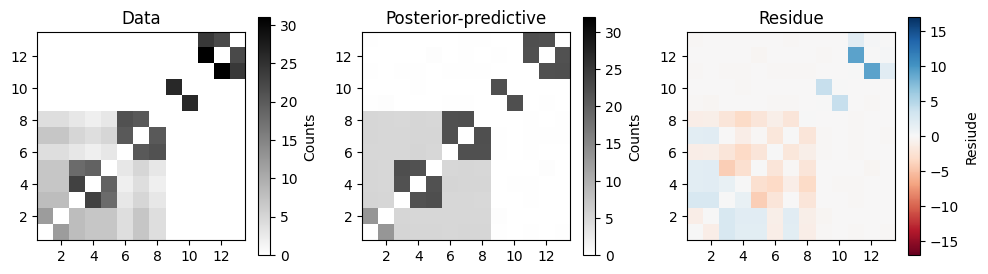

In [39]:
plt.figure(figsize=(10,2.8))

plt.subplot(131)
plt.title('Data')
plt.imshow(X, cmap=plt.cm.gray_r)
plt.colorbar(label='Counts')
set_axes()

plt.subplot(132)
plt.title('Posterior-predictive')
plt.imshow(X_tilde, vmin=0, vmax=32, cmap=plt.cm.gray_r)
plt.colorbar(label='Counts')
set_axes()


plt.subplot(133)
plt.title('Residue')
plt.imshow(X  - X_tilde, vmin=-17, vmax=17, cmap=plt.cm.RdBu)
plt.colorbar(label='Resiude')
set_axes()


plt.tight_layout(pad=1)

The residues are much smaller than before, and the posterior predictive matrix now resembles the data, minus random fluctuations.

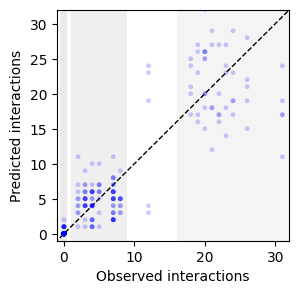

In [40]:
plt.figure(figsize=(3, 3))
for sample_id in range(5):
    # create artificial data sets
    Q0 = Q_samples[sample_id, :, :, 0]
    Q1 = Q_samples[sample_id, :, :, 1]
    U = np.random.rand(X.shape[0], X.shape[1])
    A = (U < Q1) * 1 + (U > (Q0 + Q1)) * 2
    A[np.triu_indices(13, k=1)] = A.T[np.triu_indices(13, k=1)]
    X_tilde_0 = np.random.poisson(rates[sample_id, 0], size=Q0.shape)
    X_tilde_1 = np.random.poisson(rates[sample_id, 1], size=Q1.shape)
    X_tilde_2 = np.random.poisson(rates[sample_id, 2], size=Q2.shape)
    X_tilde = (A == 0) * X_tilde_0 + (A == 1) * X_tilde_1 + (A == 2) * X_tilde_2
    plt.scatter(X[np.triu_indices(13, k=1)], X_tilde[np.triu_indices(13, k=1)], c='blue', s=12, alpha=0.2, edgecolor='none', zorder=10)

plt.plot([-10, 50], [-10, 50], c='k', ls='--', lw=1)
plt.xlabel('Observed interactions')
plt.ylabel('Predicted interactions')
plt.xlim(-1, 32)
plt.ylim(-1, 32)
plt.gca().set_facecolor("none")
plt.gca().set_facecolor("none")
plt.axvspan(-0.5, 0.5, -1, 32, zorder=-10, alpha=0.1, color='#333333', lw=0)
plt.axvspan(1, 9, -1, 32, zorder=-10, alpha=0.075, color='#333333', lw=0)
plt.axvspan(16, 32, -1, 32, zorder=-10, alpha=0.05, color='#333333', lw=0)

We also get much closer agreement when using the scatter plot point of view.

In [41]:
def discrepancy(X, Q0, Q1, rates):
    # One can check that <X_tilde_ij> = Q_ij(0) lambda_0 + (Q_ij(1)) lambda_1 + (Q_ij(2)) lambda_2  in our model.
    E_mat = Q0 * rates[0] + Q1 * rates[1] + (1 - Q0 - Q1) * rates[2]
    # Avoid double counting and numerically ill-defined 0*log(0) by selecting indices
    idx = np.triu_indices(13, k=1)
    idx2 = np.where(X[idx] > 0)[0]
    return np.sum(X[idx][idx2] * np.log(X[idx][idx2] / E_mat[idx][idx2]))


# Compute discrepancy distribution
d_data = np.zeros(500)        # data discrepancy
d_artificial = np.zeros(500)  # artificial data discrepancy

subset = sorted(np.random.choice(range(len(rho)), size=500, replace=False))
for i, sample_id in enumerate(subset):
    # Generate artificial data set
    Q0 = Q_samples[sample_id, :, :, 0]
    Q1 = Q_samples[sample_id, :, :, 1]
    U = np.random.rand(X.shape[0], X.shape[1])
    A = (U < Q1) * 1 + (U > (Q0 + Q1)) * 2
    A[np.triu_indices(13, k=1)] = A.T[np.triu_indices(13, k=1)]
    X_tilde_0 = np.random.poisson(rates[sample_id, 0], size=Q0.shape)
    X_tilde_1 = np.random.poisson(rates[sample_id, 1], size=Q1.shape)
    X_tilde_2 = np.random.poisson(rates[sample_id, 2], size=Q2.shape)
    X_tilde = (A == 0) * X_tilde_0 + (A == 1) * X_tilde_1 + (A == 2) * X_tilde_2
    X_tilde[np.triu_indices(13, k=1)] = X_tilde.T[np.triu_indices(13, k=1)]
    # calculate discrepancy
    d_data[i] = discrepancy(X, Q0, Q1, rates[sample_id, :])
    d_artificial[i] = discrepancy(X_tilde, Q0, Q1, rates[sample_id, :])

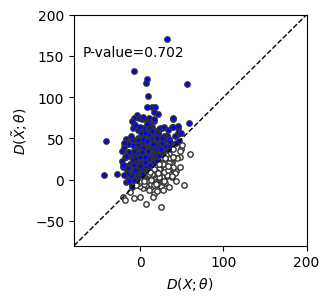

In [42]:
plt.figure(figsize=(3,3))
plt.scatter(d_data[d_data<d_artificial], d_artificial[d_data<d_artificial], s=15, edgecolor='#333333', linewidth=1, color='blue', alpha=1)
plt.scatter(d_data[d_data>d_artificial], d_artificial[d_data>d_artificial], s=15, edgecolor='#333333', linewidth=1, color='w', alpha=1)
plt.plot([-80, 250], [-80, 250], c='k', ls='--', lw=1)
plt.xlim(-80,200)
plt.ylim(-80,200)
plt.xlabel(r'$D(X;\theta)$')
plt.ylabel(r'$D(\tilde{X};\theta)$')
plt.text(-70, 150, "P-value=" + str(len(d_artificial[d_data<d_artificial]) / 500));

The p-value shows that the data is also now typical among posterior-predictive samples. Hence our fit is good!
We can trust the improved model.

## Other models in closing

### Rapid sampling model

The data we analyzed is small so sampling isn't costly. 
However, as can be seen from the `model` blocks, samples cost O(n^2) to generate, which can be costly for large `n`.

In [43]:
print(model.code())

data {
  int<lower=1> n;
  array[n, n] int<lower=0> X;
  int T; // number of edge types
  array[T] real<lower=0> rates_std_prior;
}
parameters {
  positive_ordered[T] rates;
  simplex[T] rho;
}
model {
  for (k in 1:T)
  {
    rates[k] ~ normal(1, rates_std_prior[k]);
  }

  for (i in 1:n) {
    for (j in i + 1:n) {
      vector[T] z_ij;
      vector[T] z_max_vector;
      real z_max;
      for (k in 1:T) {
        real log_mu_ij_k = poisson_lpmf(X[i, j] | rates[k]);
        real log_nu_ij_k = log(rho[k]);

        z_ij[k] = log_mu_ij_k + log_nu_ij_k;
      }
      z_max = max(z_ij);
      z_max_vector = rep_vector(z_max, T);
      target += z_max + log_sum_exp(z_ij - z_max_vector);
    }
  }
}
generated quantities {
  array[n, n, T] real Q;
  for (i in 1:n) {
    for (k in 1:T) {
      Q[i, i, k] = 0;
    }
    for (j in i+1:n) {
      vector[T] z_ij;
      real accu;
      for (k in 1:T)
      {
        real log_mu_ij_k = poisson_lpmf(X[i, j] | rates[k]);
        real log_nu_ij_k = l

We can actually save quite a bit of computation, since in the case of our particular model, the distribution of `X[i,j]` depends only on the edge type and the value of `X[i,j]`, not the indexes. (See Section 6 of the [paper's appendix](https://arxiv.org/abs/2008.03334)). The following model implements these savings:

In [44]:
model = CmdStanModel(stan_file='../examples/fast_poisson.stan')

In [45]:
# To force recompilation:
# model = CmdStanModel(stan_file='../examples/fast_poisson.stan', force_compile=True)

In [46]:
print(model.code())

data {
  int n;    // number of non-empty pairs class
  array[n] int X; // number of pairs of nodes in each classes
  array[n] int Y; // number of observations for each class
  // Priors
  array[2] real<lower=0> rates_std_prior;
  array[2] real<lower=0> rho_prior;
}
parameters {
  positive_ordered[2] rates;
  real<lower=0, upper=1> rho;
}
model {
  rates[1] ~ normal(1, rates_std_prior[1]);
  rates[2] ~ normal(1, rates_std_prior[2]);
  rho ~ beta(rho_prior[1], rho_prior[2]);

  for (i in 1:n)
  {

    real log_mu_i_0 = poisson_lpmf(Y[i] | rates[1]);
    real log_mu_i_1 = poisson_lpmf(Y[i] | rates[2]);
    real log_nu_i_0 = bernoulli_lpmf(0 | rho);
    real log_nu_i_1 = bernoulli_lpmf(1 | rho);

    real z = 0;
    real z_i_0 = log_mu_i_0 + log_nu_i_0;
    real z_i_1 = log_mu_i_1 + log_nu_i_1;
    if (z_i_0 > z_i_1) {z += z_i_0 + log1p_exp(z_i_1 - z_i_0);}
    else {z += z_i_1 + log1p_exp(z_i_0 - z_i_1);}
    target += X[i] * z;
  }
}
generated quantities {
  array[n] real Q;
  for (i in

This model takes the *histogram* of `X` as input and generates predictions in O(max(X)) time.

In [47]:
fit = model.sample(data={'n': len(obs_in_class),
                         'X': num_in_class.astype(int),
                         'Y': obs_in_class,
                         'rates_std_prior': [100, 100],
                         'rho_prior': [1, 1]})

15:42:56 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2000 [00:00<?, ?it/s, (Warmup)]

15:42:56 - cmdstanpy - INFO - CmdStan done processing.


In [48]:
print(fit.summary())

                Mean          MCSE        StdDev           MAD            5%  \
lp__     -215.895000  5.504010e-02  1.530200e+00  1.318420e+00 -2.189130e+02   
rates[1]    0.606313  7.413790e-03  2.182990e-01  1.837490e-01  1.434170e-01   
rates[2]   14.234600  5.192960e-02  1.475040e+00  1.388790e+00  1.143710e+01   
rho         0.285917  1.921330e-03  6.407040e-02  6.145560e-02  1.926780e-01   
Q[1]        0.000002  1.449700e-07  4.086560e-06  4.573620e-07  5.117760e-08   
Q[2]        0.000565  2.320570e-04  7.850180e-03  1.019510e-05  1.153070e-06   
Q[3]        0.018773  3.949790e-03  1.037910e-01  2.262730e-04  2.423270e-05   
Q[4]        0.082541  9.063960e-03  2.251680e-01  4.976620e-03  5.093000e-04   
Q[5]        0.246916  1.260290e-02  3.225340e-01  1.002530e-01  9.694270e-03   
Q[6]        0.639852  8.509120e-03  2.883190e-01  3.919640e-01  1.590420e-01   
Q[7]        0.944772  1.802990e-03  8.464080e-02  3.139150e-02  7.739490e-01   
Q[8]        0.996245  1.665230e-04  8.79

The samples come out much faster than before, and lead to the same inferences. Hence this model can scale.

(This is because the model maps directly to a "vanilla" finite-mixture, where only the value of an entry of the array matters, not its indexes.)

### Richer network prior

We used a simple prior for the network: either an edge exists or it doesn't.
We can introduce more degree variability by adding a parameter for the degree of each node.

In [49]:
model = CmdStanModel(stan_file='../examples/poisson_data_SCM_prior.stan')

In [50]:
# To force recompilation:
# model = CmdStanModel(stan_file='../examples/poisson_data_SCM_prior.stan', force_compile=True)

Unfortunately, the model doesn't admit a condensed form like the fast implementation above, so we have to use O(n^2) loops:

In [51]:
print(model.code())

data {
  int<lower=1> n;
  array[n, n] int<lower=0> X;
  array[2] real<lower=0> rates_std_prior;
}
parameters {
  positive_ordered[2] rates;
  simplex[n] lambda;
  real<lower=0> scale;
}
model {
  rates[1] ~ normal(1, rates_std_prior[1]);
  rates[2] ~ normal(1, rates_std_prior[2]);
  scale ~ exponential(100);

  for (i in 1:n) {
    for (j in i + 1:n) {
      real log_mu_ij_0 = poisson_lpmf(X[i, j] | rates[1]);
      real log_mu_ij_1 = poisson_lpmf(X[i, j] | rates[2]);

      real r = inv_logit(scale * lambda[i] * lambda[j]);
      real log_nu_ij_0 = bernoulli_lpmf(0 | r);
      real log_nu_ij_1 = bernoulli_lpmf(1 | r);

      real z_ij_0 = log_mu_ij_0 + log_nu_ij_0;
      real z_ij_1 = log_mu_ij_1 + log_nu_ij_1;
      if (z_ij_0 > z_ij_1) {target += z_ij_0 + log1p_exp(z_ij_1 - z_ij_0);}
      else {target += z_ij_1 + log1p_exp(z_ij_0 - z_ij_1);}
    }
  }
}
generated quantities {
  array[n, n] real Q;
  for (i in 1:n) {
    Q[i, i] = 0;
    for (j in i+1:n) {
      real log_mu_ij_0 = 

Let's fit this model to the dolphin data...

In [52]:
# Sample
fit = model.sample(data={"n": X.shape[0],
                         "X": X,
                         "rates_std_prior": [100, 100]},
                   chains=4, iter_sampling=250, iter_warmup=250)

# Extract variables
rho = fit.stan_variable('rho') if 'rho' in fit.stan_variables() else None
rates = fit.stan_variable('rates')
Q_samples = fit.stan_variable('Q')

15:42:57 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/500 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/500 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/500 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/500 [00:00<?, ?it/s, (Warmup)]

15:42:58 - cmdstanpy - INFO - CmdStan done processing.


In [53]:
print(fit.summary())

                 Mean          MCSE    StdDev       MAD          5%  \
lp__      -264.615000  1.846710e-01  3.283330  3.168590 -270.753000   
rates[1]     0.113024  4.365400e-03  0.119936  0.080651    0.003925   
rates[2]    11.212400  2.754950e-02  0.844381  0.782490   10.044100   
lambda[1]    0.071621  1.884620e-03  0.065859  0.055782    0.003826   
lambda[2]    0.076726  1.918960e-03  0.068381  0.055885    0.004602   
...               ...           ...       ...       ...         ...   
Q[13,9]      0.000020  4.589710e-07  0.000015  0.000012    0.000004   
Q[13,10]     0.000020  4.589700e-07  0.000015  0.000012    0.000004   
Q[13,11]     1.000000           NaN  0.000000  0.000000    1.000000   
Q[13,12]     1.000000           NaN  0.000000  0.000000    1.000000   
Q[13,13]     0.000000           NaN  0.000000  0.000000    0.000000   

                  50%         95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__      -264.215000 -259.959000   381.271   450.841     537.759  1.0

In [54]:
Q = np.mean(Q_samples, axis=0)

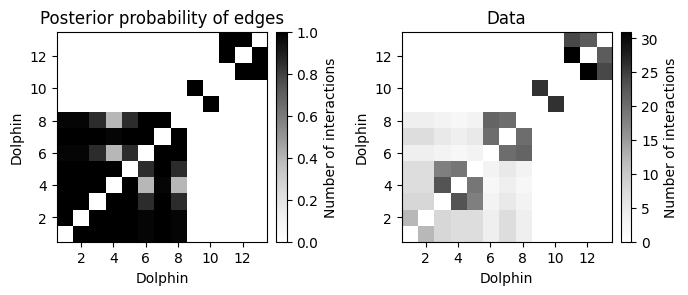

In [55]:
plt.figure(figsize=(7,3))
plt.subplot(121)
plt.title('Posterior probability of edges')
set_axes()
im=plt.imshow(Q, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im,fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')


plt.subplot(122)
plt.title('Data')
im=plt.imshow(X, cmap=plt.cm.Greys)
set_axes()
plt.colorbar(im,fraction=0.046, pad=0.04, label='Number of interactions')
plt.xlabel('Dolphin')
plt.ylabel('Dolphin')
plt.tight_layout()

Comparing to previous results, we see that this model doesn't differ much from the previous one. 
It predicts a slightly smaller average `lambda_1` and a slightly higher number of edges.

# In conclusion

Thanks for reading this far! We just reproduced every figure of the first case study of ["Bayesian inference of network structure from unreliable data,"](https://academic.oup.com/comnet/article/8/6/cnaa046/6161493), by [J.-G. Young](http://jgyoung.ca), [G. T. Cantwell](https://www.george-cantwell.com/), and [M.E.J. Newman](http://www-personal.umich.edu/~mejn/).

Get in touch at <jean-gabriel.young@uvm.edu>, or via the [issues](https://github.com/jg-you/noisy-networks-measurements/issues) if you need further guidance.